In [1]:
import json
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

# Load JSON data
with open('../Resources/CME_Data.json', 'r') as f:
    cme_data = json.load(f)

# Flatten and extract features
records = []
for event in cme_data:
    for analysis in event.get('cmeAnalyses', []):
        record = {
            'speed': analysis.get('speed'),
            'halfAngle': analysis.get('halfAngle'),
            'latitude': analysis.get('latitude'),
            'longitude': analysis.get('longitude'),
        }
        if all(v is not None for v in record.values()):  # drop incomplete records
            records.append(record)

df = pd.DataFrame(records)

In [2]:
cme_data[0]

{'activityID': '2010-04-03T09:54:00-CME-001',
 'catalog': 'M2M_CATALOG',
 'startTime': '2010-04-03T09:54Z',
 'instruments': [{'displayName': 'STEREO A: SECCHI/COR2'},
  {'displayName': 'SOHO: LASCO/C2'},
  {'displayName': 'SOHO: LASCO/C3'},
  {'displayName': 'STEREO B: SECCHI/COR2'}],
 'sourceLocation': 'S20E05',
 'activeRegionNum': 'Unknown',
 'note': 'SDO images were unavailable. CME source location determined using SOHO EIT 195. Significant dimming at time of eruption followed by post eruption arcades.',
 'submissionTime': '2015-06-17T19:47Z',
 'versionId': 1,
 'link': 'https://webtools.ccmc.gsfc.nasa.gov/DONKI/view/CME/8675/-1',
 'cmeAnalyses': [{'isMostAccurate': True,
   'time21_5': '2010-04-03T17:16Z',
   'latitude': 7.0,
   'longitude': 8.0,
   'halfAngle': 26.0,
   'speed': 620.0,
   'type': 'C',
   'featureCode': 'null',
   'imageType': None,
   'measurementTechnique': 'null',
   'note': '',
   'levelOfData': 0,
   'tilt': None,
   'minorHalfWidth': None,
   'speedMeasuredAtH

In [3]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df)

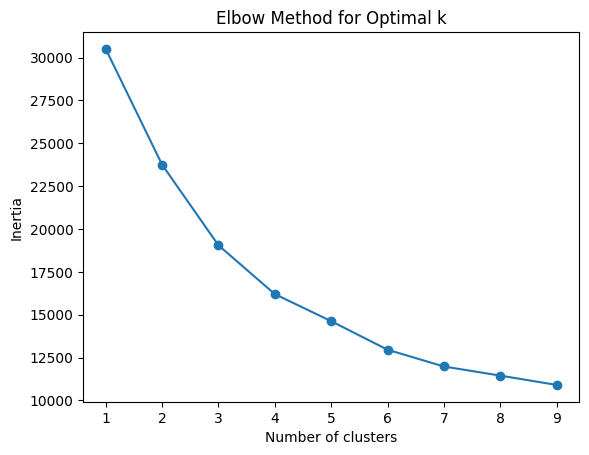

In [4]:
inertias = []
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)

plt.plot(range(1, 10), inertias, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

In [5]:
kmeans = KMeans(n_clusters=3, random_state=42)  # adjust k based on elbow
df['cluster'] = kmeans.fit_predict(X_scaled)

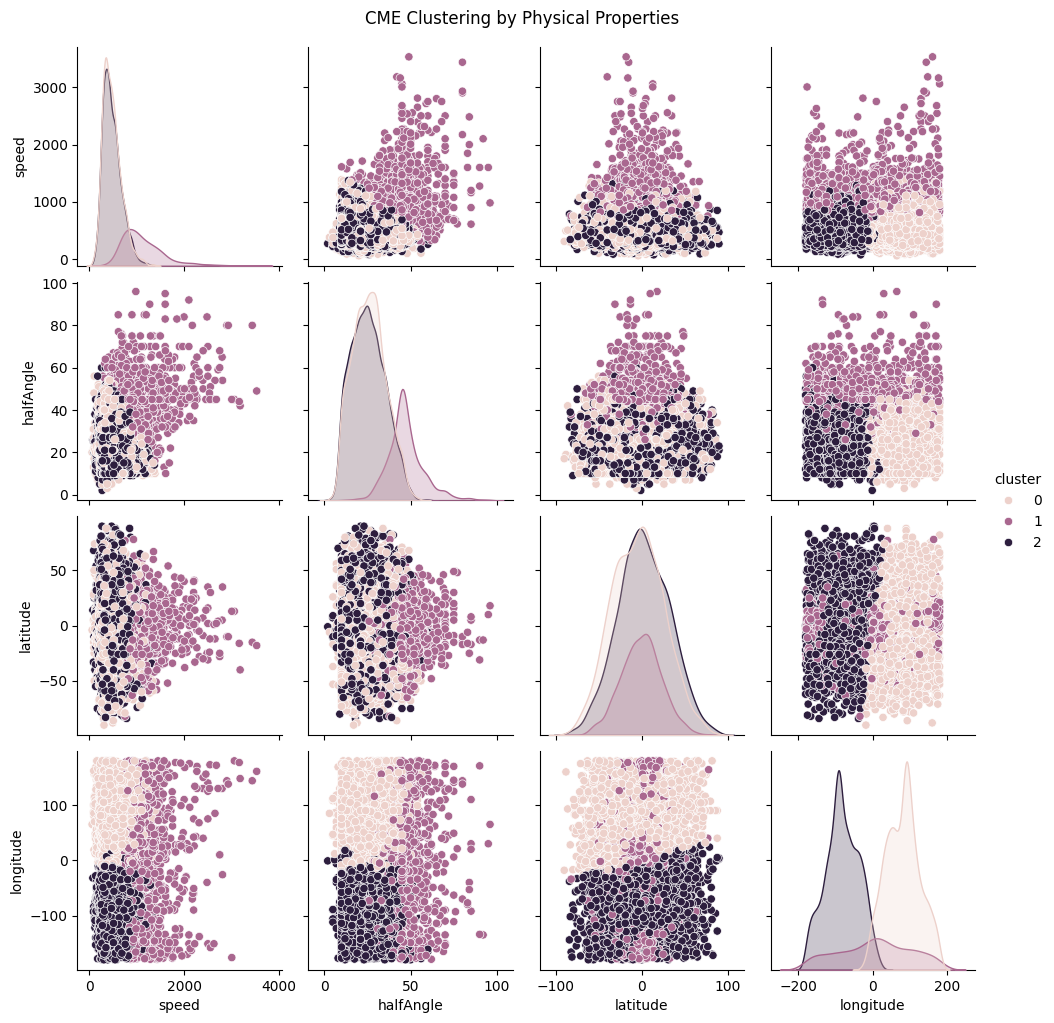

In [ ]:
"""
I was Looking for anything interesting to base a model off of.
"""

sns.pairplot(df, hue='cluster')
plt.suptitle('CME Clustering by Physical Properties', y=1.02)
plt.show()


In [7]:
cluster_summary = df.groupby('cluster').agg({
    'speed': ['mean', 'min', 'max'],
    'halfAngle': ['mean', 'min', 'max'],
    'latitude': ['mean', 'min', 'max'],
    'longitude': ['mean', 'min', 'max'],
    'cluster': 'count'
}).rename(columns={'cluster': 'count'})

print(cluster_summary)


               speed                 halfAngle              latitude        \
                mean    min     max       mean   min   max      mean   min   
cluster                                                                      
0         477.760437   60.0  1386.0  25.781534   3.0  56.0 -4.491844 -90.0   
1        1121.810093  286.0  3529.0  47.010110  10.0  96.0 -0.702612 -82.0   
2         478.539605   76.0  1372.0  25.315823   2.0  60.0  2.491818 -84.0   

               longitude               count  
          max       mean    min    max count  
cluster                                       
0        88.0  80.236841  -27.0  180.0  3298  
1        78.0   5.588037 -179.0  180.0  1187  
2        90.0 -82.072875 -180.0   27.0  3141  


In [ ]:
"""
I decided to focus on the Earth-facing CMEs, which are defined as having a latitude between -10 and 10 degrees and a longitude between -20 and 20 degrees.
"""

# Define ideal impact ranges
ideal_lat_min, ideal_lat_max = -10, 10
ideal_lon_min, ideal_lon_max = -20, 20

# Filter for CMEs in the ideal Earth-facing cone
ideal_cmes = df[
    (df['latitude'].between(ideal_lat_min, ideal_lat_max)) &
    (df['longitude'].between(ideal_lon_min, ideal_lon_max))
].copy()

# Calculate impact probability based on half angle
ideal_cmes['impactProbability'] = (2 * ideal_cmes['halfAngle']) / 360

# Cap probability at 1.0
ideal_cmes['impactProbability'] = ideal_cmes['impactProbability'].clip(upper=1.0)

# Optional: Compute overall % of CMEs that are Earth-directed candidates
percentage_ideal = len(ideal_cmes) / len(df) * 100

print(f"Percentage of CMEs within ideal Earth-impact region: {percentage_ideal:.2f}%")
ideal_cmes[['latitude', 'longitude', 'halfAngle', 'impactProbability']].head()

ideal_cmes.head()


Percentage of CMEs within ideal Earth-impact region: 2.73%


,speed,halfAngle,latitude,longitude,cluster,impactProbability
0,620.0,26.0,7.0,8.0,0,0.144444
12,550.0,40.0,0.0,1.0,0,0.222222
25,400.0,50.0,3.0,20.0,0,0.277778
32,350.0,35.0,-1.0,-13.0,2,0.194444
86,550.0,38.0,-5.0,-20.0,2,0.211111


In [ ]:
"""
Loaded the data fresh and filtered for ideal CMEs along with other relevant information.
"""

# Load the JSON data into a Python list (assuming data is a list of CME events)
with open('../Resources/CME_Data.json', 'r') as f:
    data = json.load(f)

# Initialize an empty list to store filtered data
ideal_cmes = []

# Latitude, longitude, and half-angle criteria for ideal CMEs
latitude_min = -15
latitude_max = 15
longitude_min = -90
longitude_max = 90
half_angle_max = 60

# Loop through the list of CMEs
for cme in data:  # Assuming `data` is a list of dictionaries
    for analysis in cme.get('cmeAnalyses', []):  # Loop over the 'cmeAnalyses' field within each CME event
        latitude = analysis.get('latitude')
        longitude = analysis.get('longitude')
        half_angle = analysis.get('halfAngle')
        speed = analysis.get('speed')
        
        # Ensure that latitude, longitude, and half_angle are not None before making comparisons
        if latitude is not None and longitude is not None and half_angle is not None:
            # Check if the CME meets the ideal criteria
            if latitude_min <= latitude <= latitude_max and longitude_min <= longitude <= longitude_max and half_angle <= half_angle_max:
                for enlil in analysis.get('enlilList', []):  # Loop over 'enlilList'
                    kp_90 = int(enlil.get('kp_90', 0)) if enlil.get('kp_90') is not None else 0
                    kp_135 = int(enlil.get('kp_135', 0)) if enlil.get('kp_135') is not None else 0
                    kp_180 = int(enlil.get('kp_180', 0)) if enlil.get('kp_180') is not None else 0
                    # Check if kp_90 exists and if the CME has impact data
                    if kp_90 and enlil.get('impactList'):
                        for impact in enlil.get('impactList', []):  # Loop over impactList
                            # Store relevant information
                            ideal_cmes.append({
                                'activityID': cme.get('activityID'),
                                'latitude': latitude,
                                'longitude': longitude,
                                'halfAngle': half_angle,
                                'speed': speed,
                                'kp_90': round((kp_90 + kp_135 + kp_180) / 3, 2), # Avg of kp values
                                'impactLocation': impact.get('location'),
                                'arrivalTime': impact.get('arrivalTime'),
                                'isGlancingBlow': impact.get('isGlancingBlow')
                            })

# Convert the filtered data to a DataFrame
ideal_cmes_df = pd.DataFrame(ideal_cmes)

# Display the first few rows of the ideal_cmes_df
ideal_cmes_df.head()




,activityID,latitude,longitude,halfAngle,speed,kp_90,impactLocation,arrivalTime,isGlancingBlow
0,2010-04-03T09:54:00-CME-001,7.0,8.0,26.0,620.0,4.67,STEREO A,2010-04-05T19:00Z,False
1,2010-04-03T09:54:00-CME-001,7.0,8.0,26.0,620.0,4.67,Mars,2010-04-07T11:00Z,True
2,2012-03-08T20:54:00-CME-001,-10.0,20.0,15.0,300.0,5.67,Mars,2012-03-13T05:21Z,False
3,2012-03-08T20:54:00-CME-001,-10.0,20.0,15.0,300.0,5.67,MESSENGER,2012-03-09T21:19Z,False
4,2012-03-08T20:54:00-CME-001,-10.0,20.0,15.0,300.0,6.67,Mars,2012-03-13T00:23Z,False


In [ ]:
"""
Calculating the probability of impact based on latitude, longitude, and half angle based on a fixed point of a 360-degree circle based on the ecliptic plane.
"""

import numpy as np

# Function to calculate the probability of impact based on latitude, longitude, and half angle
def calculate_impact_probability(latitude, longitude, half_angle):
    # Normalize latitude and longitude based on the ideal Earth impact zone
    lat_prob = max(0, min(1, 1 - abs(latitude) / 15))  # Latitude factor: closer to 0 is more likely
    lon_prob = max(0, min(1, 1 - abs(longitude) / 90))  # Longitude factor: closer to 0 is more likely
    
    # Half angle factor: larger half angle increases probability
    half_angle_factor = min(1, half_angle / 60)  # Assume max half angle of 60° for full impact
    
    # Combine the probabilities to get a final impact probability
    impact_probability = lat_prob * lon_prob * half_angle_factor
    
    return impact_probability

# Apply the function to the dataframe to calculate impact probability
ideal_cmes_df['impactProbability'] = ideal_cmes_df.apply(
    lambda row: calculate_impact_probability(row['latitude'], row['longitude'], row['halfAngle']), axis=1
).round(2)
ideal_cmes_df = ideal_cmes_df.drop_duplicates(subset='activityID', keep='first')

# Display the updated dataframe with impact probability
print(len(ideal_cmes_df))
ideal_cmes_df.head()


275


C:\Users\12087\AppData\Local\Temp\ipykernel_12780\2902100211.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ideal_cmes_df['impactProbability'] = ideal_cmes_df.apply(


,activityID,latitude,longitude,halfAngle,speed,kp_90,impactLocation,arrivalTime,isGlancingBlow,impactProbability
0,2010-04-03T09:54:00-CME-001,7.0,8.0,26.0,620.0,4.67,STEREO A,2010-04-05T19:00Z,False,0.21
2,2012-03-08T20:54:00-CME-001,-10.0,20.0,15.0,300.0,5.67,Mars,2012-03-13T05:21Z,False,0.06
8,2012-03-09T04:25:00-CME-001,8.0,25.0,60.0,1125.0,6.67,Mars,2012-03-13T00:23Z,False,0.34
12,2012-03-10T16:24:00-CME-001,10.0,46.0,22.0,630.0,6.67,Mars,2012-03-14T13:49Z,False,0.06
14,2012-05-11T23:54:00-CME-001,-12.0,-42.0,45.0,1040.0,4.00,Mars,2012-05-16T01:39Z,False,0.08


In [ ]:
"""
Calculating the Danger Index using XGBoost Regressor based on the impact probability, speed, and half angle.
"""

from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
import numpy as np

# Step 1: Prepare the data
features = ideal_cmes_df[['impactProbability', 'speed', 'halfAngle']]
labels = ideal_cmes_df['kp_90']

# Scale features (optional but recommended)
scaler = MinMaxScaler()
features_scaled = scaler.fit_transform(features)

# Step 2: Train-test split
X_train, X_test, y_train, y_test = train_test_split(features_scaled, labels, test_size=0.2, random_state=42)

# Step 3: Train the XGBoost Regressor
xgb_model = XGBRegressor(objective='reg:squarederror', n_estimators=50, random_state=1)
xgb_model.fit(X_train, y_train)

# Step 4: Predict Danger Index
ideal_cmes_df['DangerIndex'] = xgb_model.predict(scaler.transform(ideal_cmes_df[['impactProbability', 'speed', 'halfAngle']]))

# Optional: Round or scale the Danger Index to a 0–10 range
ideal_cmes_df['DangerIndex'] = ideal_cmes_df['DangerIndex'].clip(0, 10).round(2)
ideal_cmes_df.sort_values('DangerIndex', ascending=False, inplace=True)
# Show the updated DataFrame
print(len(ideal_cmes_df))
ideal_cmes_df[['activityID', 'halfAngle', 'impactProbability', 'speed', 'kp_90', 'DangerIndex']].head(15)


275


,activityID,halfAngle,impactProbability,speed,kp_90,DangerIndex
273,2022-07-21T01:36:00-CME-001,25.0,0.09,950.0,8.67,8.59
1062,2024-10-09T02:09:00-CME-001,14.0,0.04,1054.0,8.67,8.56
277,2022-07-21T01:48:00-CME-001,45.0,0.34,1355.0,8.67,8.56
1066,2024-10-09T02:12:00-CME-001,45.0,0.09,1509.0,8.67,8.45
1077,2024-10-24T03:48:00-CME-001,50.0,0.03,2006.0,8.33,8.27
1059,2024-10-07T20:12:00-CME-001,48.0,0.49,1345.0,8.00,7.99
1004,2024-10-01T23:09:00-CME-001,60.0,0.18,963.0,8.00,7.96
354,2023-02-17T20:23:00-CME-001,45.0,0.43,1487.0,8.00,7.63
750,2024-05-08T22:24:00-CME-001,45.0,0.42,1257.0,7.67,7.61
754,2024-05-09T09:24:00-CME-001,45.0,0.36,1330.0,7.33,7.40


In [77]:
# Define bins and labels
bins = [0, 3.33, 7.5, 10]
labels = ['Low', 'Medium', 'High']

# Create a new column with the bucketed risk category
ideal_cmes_df['DangerLevel'] = pd.cut(
    ideal_cmes_df['DangerIndex'],
    bins=bins,
    labels=labels,
    include_lowest=True
)

# Display a sample
ideal_cmes_df[['activityID', 'DangerIndex', 'DangerLevel']].head()

,activityID,DangerIndex,DangerLevel
273,2022-07-21T01:36:00-CME-001,8.59,High
1062,2024-10-09T02:09:00-CME-001,8.56,High
277,2022-07-21T01:48:00-CME-001,8.56,High
1066,2024-10-09T02:12:00-CME-001,8.45,High
1077,2024-10-24T03:48:00-CME-001,8.27,High


<Axes: xlabel='DangerLevel'>

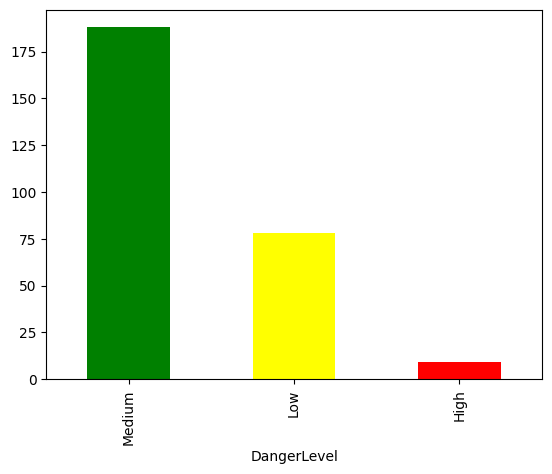

In [78]:
ideal_cmes_df["DangerLevel"].value_counts().plot(kind='bar', color=['green', 'yellow', 'red'])

In [68]:
def classify_danger(kp):
    if kp <= 3:
        return 'Low'
    elif kp <= 6:
        return 'Medium'
    else:
        return 'High'

ideal_cmes_df['DangerLevel'] = ideal_cmes_df['kp_90'].apply(classify_danger)

In [69]:
features = ideal_cmes_df[['impactProbability', 'speed', 'halfAngle']]
labels = ideal_cmes_df['DangerLevel']

In [70]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
labels_encoded = le.fit_transform(labels)

In [ ]:
"""
Messing around with a Classifier to see if I can get something more interesting.  I did not use this.
"""

from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier

X_train, X_test, y_train, y_test = train_test_split(features, labels_encoded, test_size=0.2, random_state=42)

clf = XGBClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Predict danger level
ideal_cmes_df['PredictedDangerLevel'] = le.inverse_transform(clf.predict(features))


In [72]:
from sklearn.metrics import classification_report
print(classification_report(y_test, clf.predict(X_test), target_names=le.classes_))

              precision    recall  f1-score   support

        High       0.38      0.30      0.33        10
         Low       0.38      0.31      0.34        16
      Medium       0.59      0.69      0.63        29

    accuracy                           0.51        55
   macro avg       0.45      0.43      0.44        55
weighted avg       0.49      0.51      0.50        55



In [ ]:
"""
Saving to a CSV to throw into tableau to visualize.
"""

ideal_cmes_df.to_csv('../Resources/Danger_CME_Analysis.csv', index=False)